In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score


In [2]:
df = pd.read_csv("train.csv")
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
X = df["text"].copy()
authors = df["author"].copy()

# Label data
y = []
for author in authors:
    if author == "EAP":
        y.append([1, 0, 0])
    if author == "HPL":
        y.append([0, 1, 0])
    if author == "MWS":
        y.append([0, 0, 1])

y = np.array(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(X_train)
vocab = encoder.get_vocabulary()

In [6]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [7]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [8]:
callbacks = [
          tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
          tf.keras.callbacks.ModelCheckpoint(
            filepath="BiLSTM_weights",
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
]
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_test, y_test),
                    validation_steps=30,
                    callbacks=callbacks)

Epoch 1/15
490/490 [==============================] - 67s 102ms/step - loss: 0.6327 - accuracy: 0.7253 - val_loss: 0.4509 - val_accuracy: 0.8202
Epoch 2/15
490/490 [==============================] - 44s 91ms/step - loss: 0.2213 - accuracy: 0.9199 - val_loss: 0.4741 - val_accuracy: 0.8269
Epoch 3/15
490/490 [==============================] - 45s 91ms/step - loss: 0.1020 - accuracy: 0.9646 - val_loss: 0.5738 - val_accuracy: 0.8118
Epoch 4/15
490/490 [==============================] - 45s 91ms/step - loss: 0.0655 - accuracy: 0.9775 - val_loss: 0.6264 - val_accuracy: 0.8123
Epoch 5/15
490/490 [==============================] - 45s 91ms/step - loss: 0.0431 - accuracy: 0.9860 - val_loss: 0.7390 - val_accuracy: 0.8154


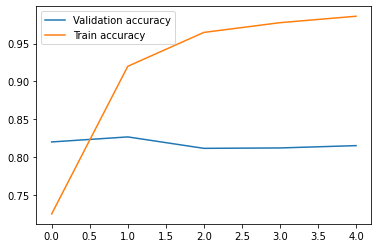

In [9]:
# Plot accuracy as a function of the epoch number
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.legend()

In [10]:
def confusion(predictions, test_labels):
    matrix = np.zeros([3,3], dtype=int)
    
    i = 0
    for row in predictions:
        matrix[np.argmax(row), np.argmax(test_labels[i])] += 1
        i += 1
        
    return matrix

In [11]:
model.load_weights("BiLSTM_weights")
print(model.evaluate(X_test, y_test))
predict = model.predict(X_test)

123/123 [==============================] - 4s 33ms/step - loss: 0.4741 - accuracy: 0.8269
[0.4740798771381378, 0.8268641233444214]


Text(33.0, 0.5, 'True')

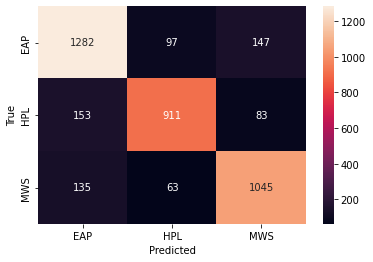

In [12]:
x_axis_labels = ['EAP', 'HPL', 'MWS']
y_axis_labels = ['EAP', 'HPL', 'MWS']

ax = sns.heatmap(confusion(predict, y_test), xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [13]:
df_sub = pd.read_csv("test.csv")
X_sub = df_sub["text"].copy()

In [14]:
submission_pred = model.predict(X_sub)
submission_pred

array([[1.04538925e-01, 8.16213433e-03, 8.87299001e-01],
       [9.92013156e-01, 7.02258851e-03, 9.64273058e-04],
       [9.96656367e-04, 9.98605907e-01, 3.97537224e-04],
       ...,
       [6.65341079e-01, 9.49359089e-02, 2.39723042e-01],
       [2.92299658e-01, 5.19721247e-02, 6.55728221e-01],
       [4.97600995e-04, 9.99394536e-01, 1.07813867e-04]], dtype=float32)

In [15]:
submission = pd.DataFrame({
    "id": df_sub["id"],
    "EAP": submission_pred[:, 0],
    "HPL": submission_pred[:, 1],
    "MWS": submission_pred[:, 2]
})
submission

,id,EAP,HPL,MWS
0,id02310,0.104539,0.008162,0.887299
1,id24541,0.992013,0.007023,0.000964
2,id00134,0.000997,0.998606,0.000398
3,id27757,0.786319,0.187863,0.025819
4,id04081,0.953295,0.023866,0.022839
...,...,...,...,...
8387,id11749,0.311637,0.016237,0.672125
8388,id10526,0.008189,0.004304,0.987507
8389,id13477,0.665341,0.094936,0.239723
8390,id13761,0.292300,0.051972,0.655728


In [16]:
submission.to_csv("submission.csv", index=False)